In [1]:
using Gen
using Random
using CairoMakie
using Distributions
using StatsBase

# Blackjack Gen Model

##### Types

In [2]:
const Card = Union{Symbol, Int}
const State = Tuple{Int, Card, Bool}
const Policy = Dict{State, Float64}

CARD_MAP = [:ace, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten, :jack, :queen, :king];

##### Helper functions

In [3]:

function sort_hand(hand)
    # aces should be last
    return sort(hand, lt=(x,y) -> x != :ace)
end

function get_value(card, sum_so_far)
    if card == :ace
        if sum_so_far + 11 <= 21
            return 11
        else
            return 1
        end
    elseif card == :jack || card == :queen || card == :king
        return 10
    else
        # get index in card map
        return findfirst(x -> x == card, CARD_MAP)
    end
end

function get_sum(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        sum += get_value(card, sum)
    end
    return sum
end

function holds_usable_ace(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        value = get_value(card, sum)    
        if value == 11
            return true
        end
        sum += value
    end
    return false
end

function states()
    states = []
    for i in 4:21
        for j in 1:13
            for k in [true, false]
                push!(states, (i, CARD_MAP[j], k))
            end
        end
    end
    return states
end

STATES = states();

##### Helper distributions

In [4]:
@dist function draw_card()
    card = uniform_discrete(1,13)
    CARD_MAP[card]
end;


##### Plot

In [5]:

function plot_policy(policy::Policy)
    
    # Define ranges for player sums and dealer showing cards
    player_sums = 12:21  # x-axis
    dealer_showing = 1:13  # y-axis

    # Initialize z-values based on the policy
    z_true = zeros(Float64, length(player_sums), length(dealer_showing))
    z_false = zeros(Float64, length(player_sums), length(dealer_showing))

    # Populate z-values based on the policy
    for i in player_sums
        for j in dealer_showing
            card = CARD_MAP[j]
            z_true[i - 11, j] = policy[(i, card, true)]
            z_false[i - 11, j] = policy[(i, card, false)]
        end
    end

    # Create figure
    fig = Figure(resolution = (800, 600))

    # Surface plot with usable ace
    ax1 = Axis3(fig[1, 1], title = "Usable Ace")
    surface!(ax1, player_sums, dealer_showing, z_true)
    ax1.xlabel = "Player sum"
    ax1.ylabel = "Dealer showing"
    ax1.zlabel = "1 = Hit, 0 = Stick"

    # Surface plot without usable ace
    ax2 = Axis3(fig[1, 2], title = "No Usable Ace")
    surface!(ax2, player_sums, dealer_showing, z_false)
    ax2.xlabel = "Player sum"
    ax2.ylabel = "Dealer showing"
    ax2.zlabel = "1 = Hit, 0 = Stick"

    # Display the figure
    display(fig)
end

function most_frequent_policy(dict_list::Vector{Policy})
    # Dictionary to count occurrences of each dictionary
    dict_counts = Dict{Policy, Int}()
    
    for d in dict_list
        # Increment count for each dictionary
        dict_counts[d] = get(dict_counts, d, 0) + 1
    end
    
    # Find the dictionary with the maximum count
    most_frequent = argmax(dict_counts)
    
    return most_frequent, dict_counts[most_frequent]  # Return the most frequent dict and its count
end


function plot_mean_policy_from_traces(traces)
    mean_pol = Policy()
    for state in STATES 
        mean_pol[state] = mean(Float64[run[:policy => state] for run in traces if has_value(get_choices(run), :policy => state)])
    end

    plot_policy(mean_pol)
end;

function plot_policy_from_trace(trace)
    plot_mean_policy_from_traces([trace])
end;

## Model

In [6]:
@gen function blackjack_model(policy: Policy)
    sum = 0

    # Player
    card1 = {:card => 1} ~ draw_card()
    card2 = {:card => 2} ~ draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card = {:dealer => 1} ~ draw_card()
    dealer_visible_card = {:dealer => 2} ~ draw_card()

    sum = get_sum(hand)
    state = (sum, dealer_visible_card, holds_usable_ace(hand))

    playing = true
    # Player's turn
    for i in 3:11 
        card = {:card => i} ~ draw_card()
        action = policy[state]
        if playing && action == 1
            push!(hand, card)
            sum = get_sum(hand)
            if sum > 21
                playing = false
            else 
                state = (sum, dealer_visible_card, holds_usable_ace(hand))
            end
        else
            playing = false
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    playing = true
    for i in 3:11
        card = {:dealer => i} ~ draw_card()
        if playing && dealer_sum < 17
            push!(dealer_hand, card)
            dealer_sum = get_sum(dealer_hand)
        else 
            playing = false
        end
    end
    
    # Determine winner
    if sum > 21
        return 1
    elseif dealer_sum > 21
        return 1000
    elseif sum > dealer_sum
        return 1000
    elseif sum < dealer_sum
        return 1
    else
        return 500
    end

end;

## Policy selection with one run

In [7]:
@gen function select_policy()

    policy = Policy()
    for state in STATES
        policy[state] = {:policy => state} ~ bernoulli(0.5)
    end

    # play one game according to this policy
    ret = {:ret} ~ blackjack_model(policy)

    # ret is either 1, 500 or 1000 --> transform to Bernoulli
    p = ret / 1000 # max reward = 1000

    o ~ bernoulli(p)
    return policy
    
end;

### Rejection Sampling

2965


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


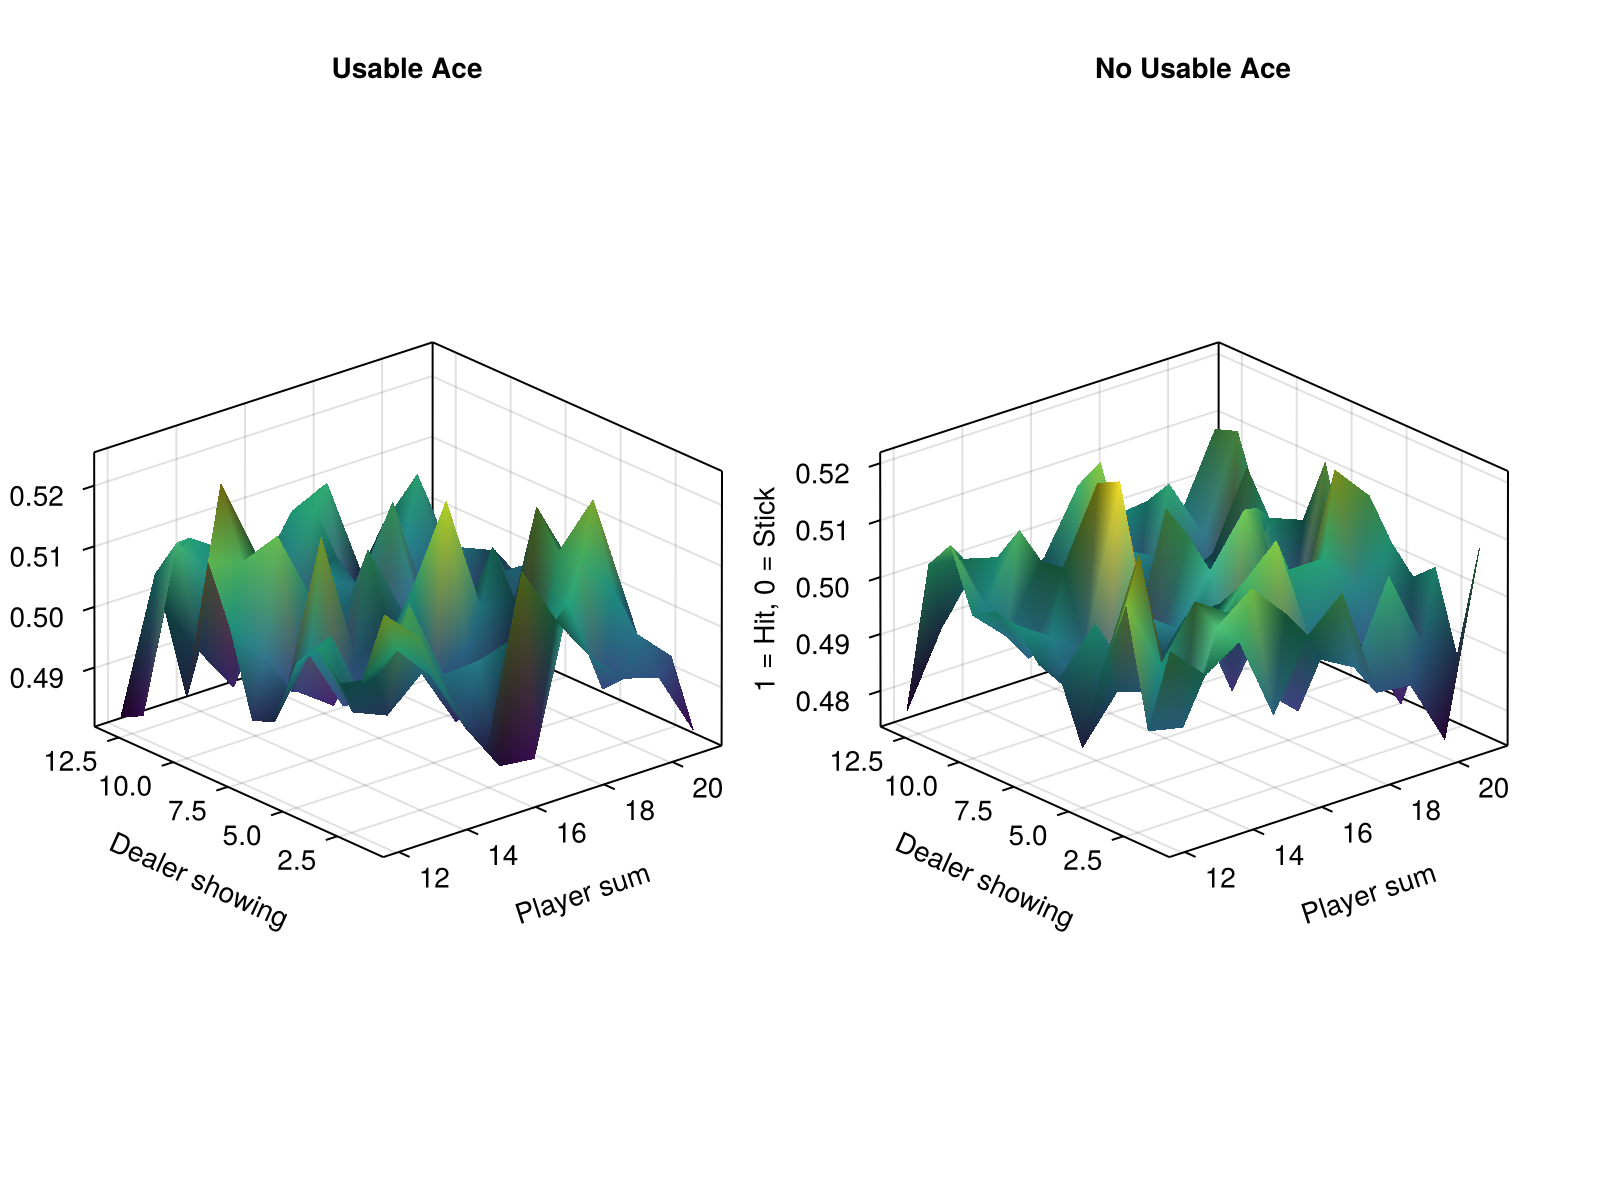

CairoMakie.Screen{IMAGE}


In [8]:
conditioned = []
for i in 1:1e4
    run = simulate(select_policy, ())
    if run[:o] == 1
        push!(conditioned, run)
    end
end
println(length(conditioned))
optimal = mode(conditioned)
plot_(conditioned)


In [9]:
# conditioned = []
# for i in 1:1e5
#     run = simulate(run_once, ())
#     if run[:o] == 1
#         push!(conditioned, run)
#     end
# end
# println(length(conditioned))

# plot_mean_policy_from_traces(conditioned)

The fact that there is a downward curve in the hit or stick action as the player sum increases is an indication that the model has learned a policy that tends to get more conservative as the player sum increases. This is a good sign that the model is learning something.

### MCMC

In [10]:
function block_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, Gen.select(:policy => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end;

When running the update 10 times, a new behavior needs to be sampled for the different states that get visited in the update. In some runs, 4 cards are drawn. This means that MH can run although the initial model is lazy and only defines part of the policy.

Let's try to run the update more times to see if the policy converges.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


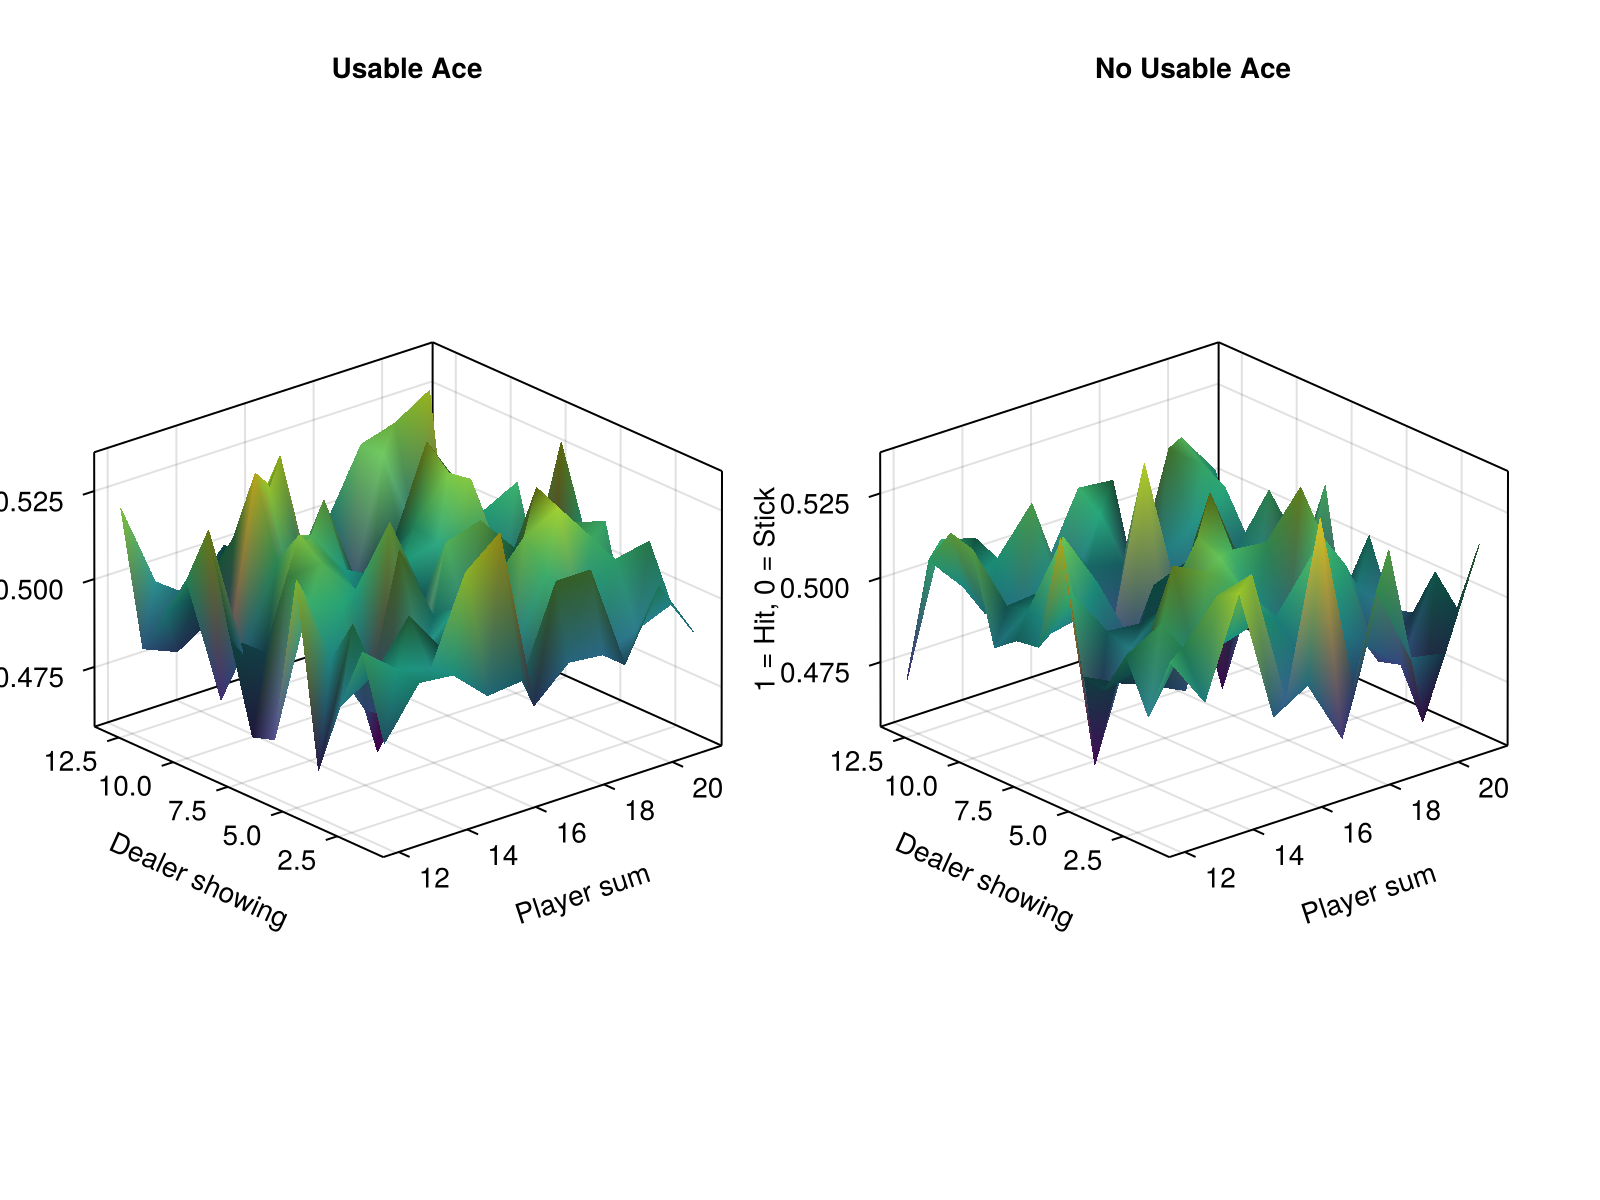

CairoMakie.Screen{IMAGE}


In [11]:
(running_trace,_) = generate(select_policy,(), choicemap((:o,1)))
traces = [running_trace]
for _ in 1:1e3
    running_trace = block_update(running_trace)
    push!(traces,running_trace)
end
plot_mean_policy_from_traces(traces)

As we can see in the usable ace plot, there are not even enough samples to get a good estimate of the policy. Many more samples are needed. Since the update proposals are not very good and the prior is uniform, the model is not learning fast. To improve this, we could add a proposal distribution for future policies that checks whether a policy for the given state exists, samples around it if it does, and samples from a uniform distribution if it does not.

#### Better Proposals


In [12]:
@gen function proposal(curr_trace, state)
    if(curr_trace[:policy => state] == 1)
        {:policy => state} ~ bernoulli(0.8)
    else
        {:policy => state} ~ bernoulli(0.2)
    end
end

function drift_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, proposal, (s,)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end;

In [13]:
(running_trace,_) = generate(select_policy,(), choicemap((:o,1)))
traces = [running_trace]
for _ in 1:1e3
    running_trace = drift_update(running_trace)
    push!(traces,running_trace)

end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


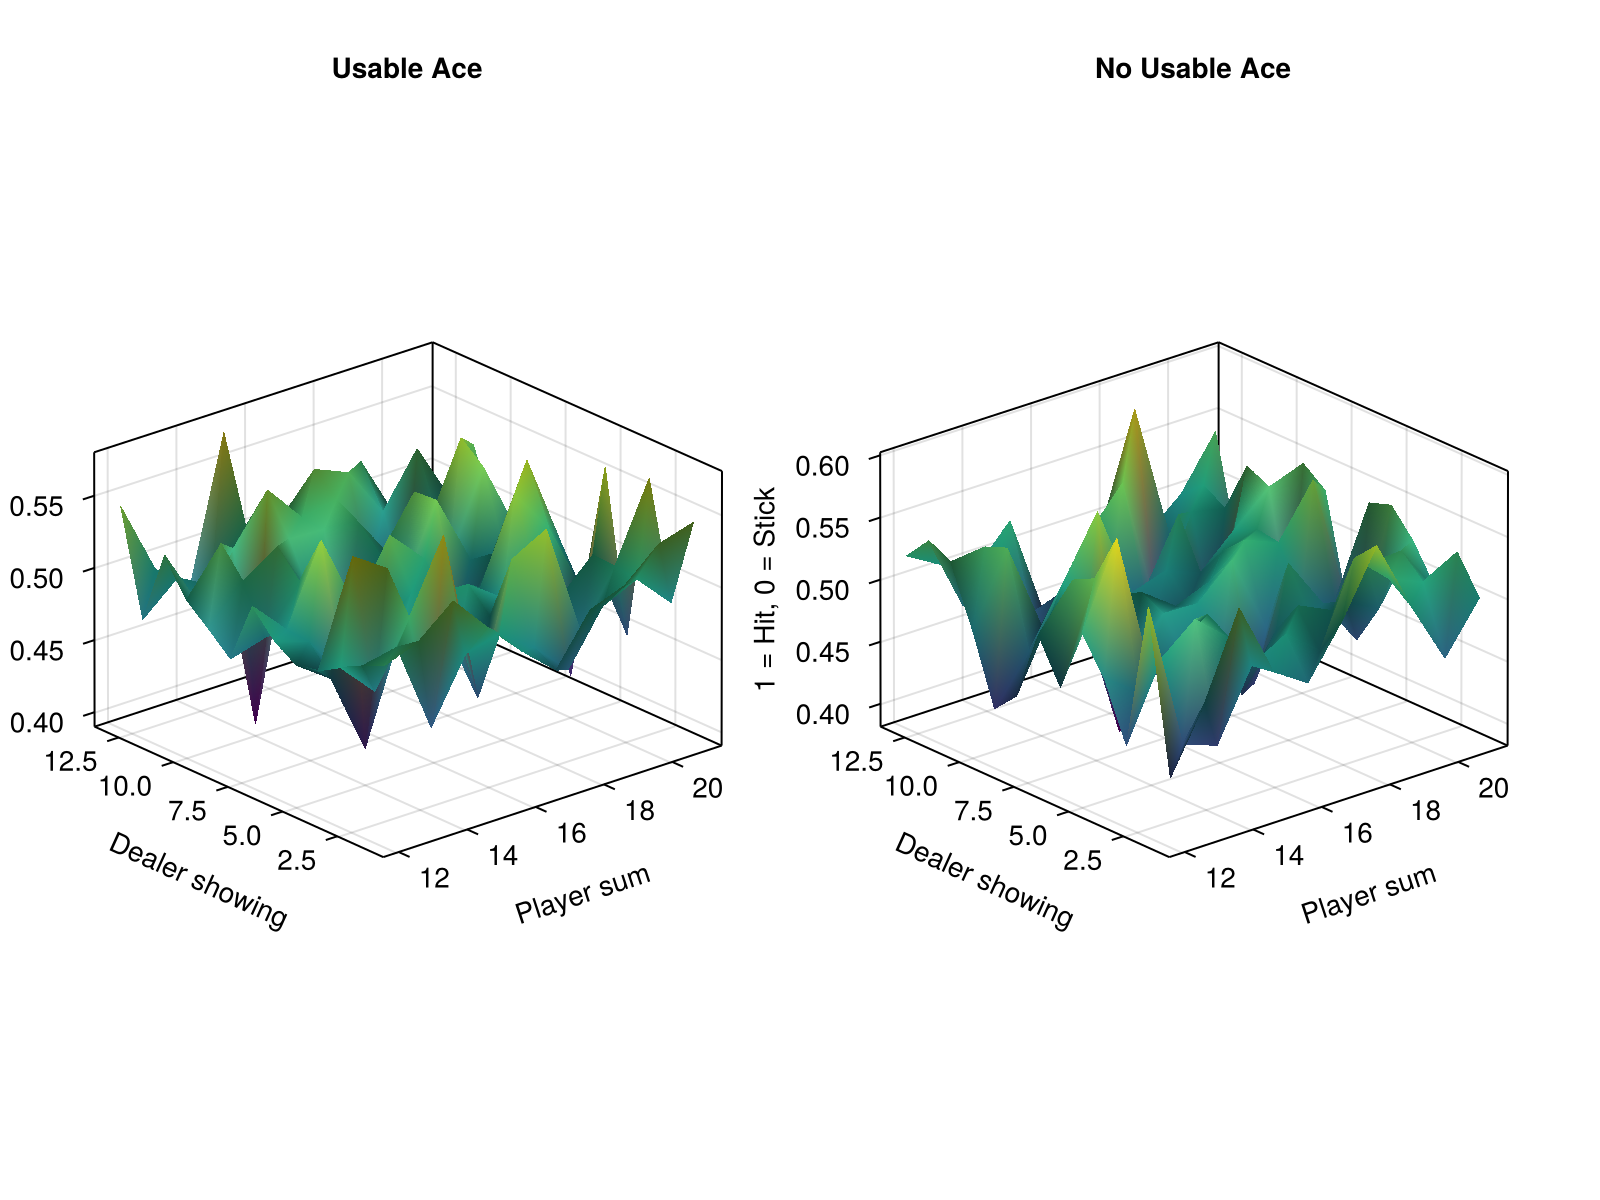

CairoMakie.Screen{IMAGE}


In [14]:
plot_mean_policy_from_traces(traces)


In [29]:
for _ in 1:1e4
    running_trace = drift_update(running_trace)
    push!(traces,running_trace)
end
plot_mean_policy_from_traces(traces[end-100:end])

In [ ]:
plot_mean_policy_from_traces(traces)

To check whether the updates and proposals are good, let's plot a the development of the policy value throughout the traces.

In [ ]:
hash_vals = []
for trace in traces[end-1000:end]
    policy = Policy()
    for state in STATES
        if(has_value(get_choices(trace), :policy => state))
            policy[state] = trace[:policy => state]
        end
    end
    push!(hash_vals, hash(policy))
end

fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], title = "Policy Hash Values Over Time")
lines!(ax, 1:length(hash_vals), hash_vals, label = "Hash Values")
ax.xlabel = "Trace Index"
ax.ylabel = "Hash Value"
display(fig)

Let's try choosing the proposal according to a mean value of past policies and see if the model learns faster and how the policy develops

In [199]:
@gen function mean_proposal(curr_trace, state, mean_policy)
    if(haskey(mean_policy, state) && has_value(get_choices(curr_trace), :policy => state))
        policy = {:policy => state} ~ bernoulli(mean_policy[state])
    end
end

function mean_update(trace, mean_policy::Policy)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, mean_proposal, (s,mean_policy)) 
        (trace,_) = mh(trace, Gen.select(:ret => :action => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end;

In [ ]:
traces = [first_trace]
running_trace = first_trace
mean_policy = Policy()
val_counts = Dict{State, Int}()
for _ in 1:1e4
    for state in STATES
        if has_value(get_choices(running_trace), :policy => state)
            val_counts[state] = haskey(val_counts, state) ? val_counts[state] + 1 : 1
            mean_policy[state] = (haskey(mean_policy, state) ? mean_policy[state] : 0.5 + running_trace[:policy => state]) / val_counts[state]
        end
    end
    running_trace = mean_update(running_trace, mean_policy)
    push!(traces,running_trace)
end
plot_mean_policy_from_traces(traces)

running another 1e4 times:

In [ ]:

for _ in 1:1e4
    for state in STATES
        if has_value(get_choices(running_trace), :policy => state)
            val_counts[state] = haskey(val_counts, state) ? val_counts[state] + 1 : 1
            mean_policy[state] = haskey(mean_policy, state) ? (mean_policy[state] + running_trace[:policy => state]) / val_counts[state] : running_trace[:policy => state]
        end
    end
    running_trace = mean_update(running_trace, mean_policy)
    push!(traces,running_trace)
end
plot_mean_policy_from_traces(traces)